In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np
import pickle
from math import factorial as fac
from math import exp, sqrt, pi, comb, cos, sin, floor

Generalised Laugerre Polynomial

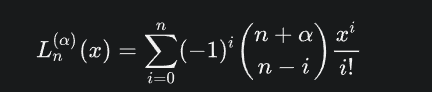

Associated Legendre Polynomial (m>0)

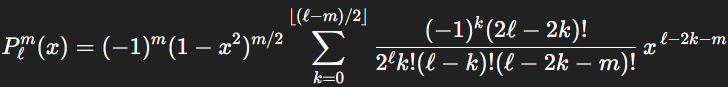
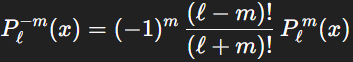

Radial Wave Function

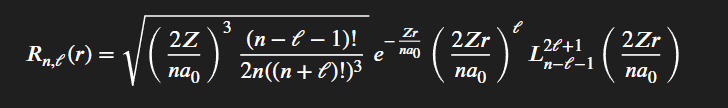

Angular Wave Function

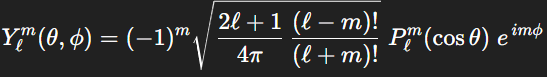

Final Electron Wave Function

image.png

In [ ]:
a0 = 0.529 #Angstrom
Z = 1

def Laguerre(n, a, x):
  # Evaluating generalised laguerre polynomial Ln(x)
  s=0
  for k in range(n+1):
    s+=((x**k)/fac(k))*comb(n+a, n-k)*(-1)**k
  return s

def Legendre(l, m, x):
  # Evaluating Associated Legendre polynomial Pn(x)
  s = 0
  for k in range(floor((l-m)/2)+1):
    s += (fac(2*l - 2*k)*(-1)**k)*x**(l-2*k-m)/(fac(l-2*k-m)*fac(l-k)*fac(k)*2**l)
  return ((-1)**m)*((1-x**2)**(m/2))*s

def radial(n, l, r):
  # Normalization constant
  #N0 = [[], [5.1981], [1.8378, 1.0028]]
  N0 = sqrt((2/(n*a0))**3*(fac(n-l-1)/(2*n*fac(n+l))))
  # Laguerre polynomial term
  Lnx = Laguerre(n-l-1, 2*l+1, 2*r*Z/(n*a0))
  # Exponential term
  ex = (2*Z*r/(n*a0))**l*exp(-r*Z/(n*a0))

  return N0*Lnx*ex

def angular(l, m, theta, phi):
  N0 = sqrt(((2*l+1)*fac(l-m))/((4*pi)*fac(l+m)))
  Pnx = Legendre(l, abs(m), cos(theta))

  if m < 0:
    Pnx = (-1)**(-m)*(fac(l+m)/fac(l-m))*(-Pnx)

  ex = np.exp(1j*m*phi)

  return (-1)**m*N0*Pnx*ex

def sai(n, l, m, r, theta, phi):
  return radial(n, l, r)*angular(l, m, theta, phi)

# Checking if Normalization Factor in Radial and Angular wave functions is correct, by integrating probability in space and making sure it approximates to 1.

Radial Normalization Check

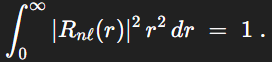

In [ ]:
s = 0
for r in np.arange(0, 8, 0.05):
  s+=0.05*r*r*abs(radial(2, 1, r))**2
print("Total integrated probability of radial wave fn: ", s)

Total integrated probability of radial wave fn:  0.9991909880727604


Angular Normalization Check

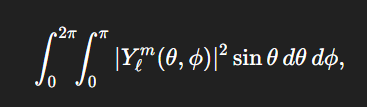

In [ ]:
s = 0
for phi in np.arange(0, 2*pi, 0.05):
  for theta in np.arange(0, pi, 0.05):
    s += sin(theta)*abs(angular(0, 0, theta, phi))**2*(0.05**2)
print("Total integrated probability of angular wavefn: ", s)

Total integrated probability of angular wavefn:  1.0025548993788076


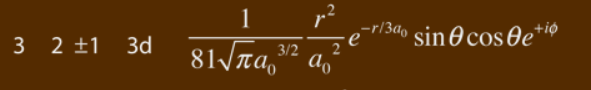

# Sample plot of Ψ against distance along a certain direction vector, for certain value of quantum numbers n, l, m.

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


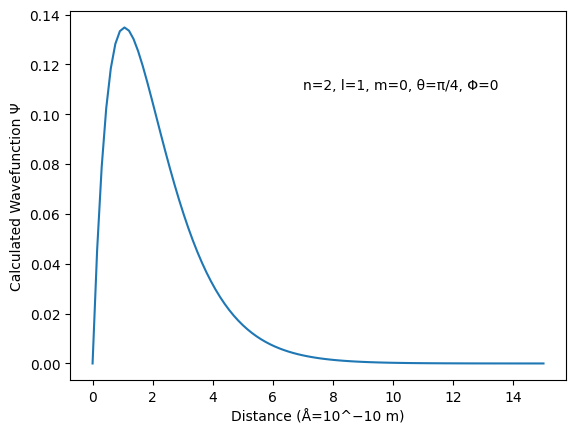

In [ ]:
theta = pi/4
phi = 0

def sai3d1_calc(r):
  return sai(2, 1, 0, r, theta, phi)

x = np.linspace(0, 15, 100)
y = np.vectorize(sai3d1_calc)(x)

plt.plot(x, y)
plt.xlabel("Distance (Å=10^−10 m)")
plt.ylabel("Calculated Wavefunction Ψ")
plt.text(7, 0.11, "n=2, l=1, m=0, θ=π/4, Φ=0")
plt.show()

# Functions for computation of probability and rendering

In [ ]:

x1 = []
y1 = []
z1 = []
prob1 = []

x2 = []
y2 = []
z2 = []
prob2 = []

def compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=False, CI=True):
  # r, theta, phi in angstrom and radian
  for r in np.arange(0, r+dr, dr):
    for theta in np.arange(0, pi, dtheta):
      for phi in np.arange(0, 2*pi, dphi):
        v = sai(n, l, m, r, theta, phi)
        if LCAO:
          # do point combination of orbitals, if LCAO is set (Constructive/Destructive)
          v += sai(n, l, -m, r, theta, phi) if CI else -sai(n, l, -m, r, theta, phi)
          v /= sqrt(2)

        p = (abs(v)**2)*((r**2)*sin(theta)*dr*dtheta*dphi)

        if v>0:
          x1.append(r*sin(theta)*cos(phi))
          y1.append(r*sin(theta)*sin(phi))
          z1.append(r*cos(theta))

          prob1.append(p)
        elif v<0:
          x2.append(r*sin(theta)*cos(phi))
          y2.append(r*sin(theta)*sin(phi))
          z2.append(r*cos(theta))

          prob2.append(p)

  print("Total electron probability in integrated volume: ", sum(prob1)+sum(prob2))


def render_plot(fig, dotSize, opaqueMode=False, opaqueThreshold=0.05, opacity=1):
  if len(prob1) > 0:
    npProb1 = np.array(prob1)
    pMin1 = np.min(npProb1)
    pMax1 = np.max(npProb1)

    gradient1 = list((npProb1 - pMin1)/(pMax1-pMin1))
    data1 = None

    if opaqueMode:
      x1c = x1.copy()
      y1c = y1.copy()
      z1c = z1.copy()

      for i in range(len(gradient1)-1, -1, -1):
        if gradient1[i] < opaqueThreshold:
          gradient1.pop(i)
          x1c.pop(i)
          y1c.pop(i)
          z1c.pop(i)

      data1 = go.Scatter3d(
        x=x1c,
        y=y1c,
        z=z1c,
        mode='markers',
        marker=dict(
            size=dotSize,
            color=gradient1,                # set color to an array/list of desired values
            colorscale='Blues',              # choose a colorscale
            opacity=opacity
        )
      )
    else:
      BlueCustom = [
        [0.0, 'rgba(0, 0, 128, 0)'],
        [1.0, 'rgba(0, 0, 128, 1.0)']
      ]

      data1 = go.Scatter3d(
        x=x1,
        y=y1,
        z=z1,
        mode='markers',
        marker=dict(
            size=dotSize,
            color=gradient1,                # set color to an array/list of desired values
            colorscale=BlueCustom,             # choose a colorscale
        )
      )

    fig.add_trace(data1)

  if len(prob2) > 0:
    npProb2 = np.array(prob2)
    pMin2 = np.min(npProb2)
    pMax2 = np.max(npProb2)

    gradient2 = list((npProb2 - pMin2)/(pMax2-pMin2))
    data2 = None

    if opaqueMode:
      x2c = x2.copy()
      y2c = y2.copy()
      z2c = z2.copy()

      for i in range(len(gradient2)-1, -1, -1):
        if gradient2[i] < opaqueThreshold:
          gradient2.pop(i)
          x2c.pop(i)
          y2c.pop(i)
          z2c.pop(i)

      data2 = go.Scatter3d(
        x=x2c,
        y=y2c,
        z=z2c,
        mode='markers',
        marker=dict(
            size=dotSize,
            color=gradient2,                # set color to an array/list of desired values
            colorscale='Reds',               # choose a colorscale
            opacity=opacity
        )
      )

    else:
      RedCustom = [
        [0.0, 'rgba(128, 0, 0, 0)'],
        [1.0, 'rgba(128, 0, 0, 1.0)']
      ]

      data2 = go.Scatter3d(
        x=x2,
        y=y2,
        z=z2,
        mode='markers',
        marker=dict(
            size=dotSize,
            color=gradient2,                # set color to an array/list of desired values
            colorscale=RedCustom            # choose a colorscale
        )
      )

    fig.add_trace(data2)

def clear_data():
  x1.clear()
  x2.clear()
  y1.clear()
  y2.clear()
  z1.clear()
  z2.clear()
  prob1.clear()
  prob2.clear()

# Rendered Demos of Different Orbitals

## 1s


In [ ]:
name = "1s"
n = 1
l = 0
m = 0
r = 4
dr = 0.075
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi)

Total electron probability in integrated volume:  1.0025016639405493


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=False, opaqueThreshold=0.3)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, m={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 2py


In [ ]:
name = "2Py"
n = 2
l = 1
m = 1
r = 7
dr = 0.1
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=False)

Total electron probability in integrated volume:  0.9970494868846714


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=False, opaqueThreshold=0.3)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 2px

In [ ]:
name = "2Px"
n = 2
l = 1
m = 1
r = 7
dr = 0.1
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=True)

Total electron probability in integrated volume:  1.0023850086318702


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=False, opaqueThreshold=0.05)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 2pz

In [ ]:
name = "2Pz"
n = 2
l = 1
m = 0
r = 7
dr = 0.1
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi)

Total electron probability in integrated volume:  0.9993544291836729


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 3d dxz

In [ ]:
name = "3D dxz"
n = 3
l = 2
m = 1
r = 12
dr = 0.3
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=True)


Total electron probability in integrated volume:  1.0004348352692558


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 3d dz^2

In [ ]:
name = "3D dz^2"
n = 3
l = 2
m = 0
r = 12
dr = 0.3
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi)

Total electron probability in integrated volume:  0.9971681916352957


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.35)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 3d dx^2-y^2

In [ ]:
name = "3D dx^2-y^2"
n = 3
l = 2
m = 2
r = 12
dr = 0.3
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=False)

Total electron probability in integrated volume:  1.0004331098043306


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 3d dxy

In [ ]:
name = "3D dxy"
n = 3
l = 2
m = 2
r = 12
dr = 0.3
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=True)

Total electron probability in integrated volume:  0.9951108674753586


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## n=3 Family Superimposed

In [ ]:


name = "n=3 family [All Super Imposed]"
n = 3
r = 12
dr = 0.2
dtheta = 0.05
dphi = 0.05

fig = go.Figure()

dotSize = 0.5

for l in range(n):
  print(f"Initiating l={l}")
  clear_data()
  compute_probabilities(n, l, 0, r, dr, dtheta, dphi)
  render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.3)
  print("Rendered data for m=0")

  for m in range(1, l+1):
    clear_data()
    compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=True)
    render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.3)
    print(f"Rendered data for m={m} (constructive)")

    clear_data()
    compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=True, CI=False)
    render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.3)
    print(f"Rendered data for m={m} (destructive)")
  print(f"Finished l={l}")

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name
)

with open("3_Superimposed_fig.bin", "wb") as f:
  pickle.dump(fig, f)
  print("Data saved")

Initiating l=0
Total electron probability in integrated volume:  0.9739407983281011
Rendered data for m=0
Finished l=0
Initiating l=1
Total electron probability in integrated volume:  0.9834834989763457
Rendered data for m=0
Total electron probability in integrated volume:  0.9864659492387509
Rendered data for m=1 (constructive)
Total electron probability in integrated volume:  0.9812151618868863
Rendered data for m=1 (destructive)
Finished l=1
Initiating l=2
Total electron probability in integrated volume:  0.9955493056869509
Rendered data for m=0
Total electron probability in integrated volume:  0.9988106459794042
Rendered data for m=1 (constructive)
Total electron probability in integrated volume:  0.9934941499453873
Rendered data for m=1 (destructive)
Total electron probability in integrated volume:  0.9934953215585455
Rendered data for m=2 (constructive)
Total electron probability in integrated volume:  0.9988089233157722
Rendered data for m=2 (destructive)
Finished l=2
Data saved

In [ ]:
with open("3_Superimposed_fig.bin", "rb") as f:
  fig = pickle.load(f)
  fig.show()

In [ ]:
with open("3D_Superimposed_fig.bin", "rb") as f:
  fig = pickle.load(f)
  fig.show()

## 4f (m=0)

In [ ]:
name = "4F"
n = 4
l = 3
m = 0
r = 18
dr = 0.4
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=False, CI=True)

Total electron probability in integrated volume:  0.9906040190245392


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.35)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, m={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 5g (m=0)

In [ ]:
name = "5G"
n = 5
l = 4
m = 0
r = 25
dr = 0.5
dtheta = 0.05
dphi = 0.05

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=False, CI=True)

Total electron probability in integrated volume:  0.9841157378440284


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.35)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, |m|={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()

## 10l (m=0)

In [ ]:
name = "10L"
n = 10
l = 9
m = 0
r = 100
dr = 1.2
dtheta = 0.03
dphi = 0.03

clear_data()
compute_probabilities(n, l, m, r, dr, dtheta, dphi, LCAO=False, CI=False)

Total electron probability in integrated volume:  1.0012466716101707


In [ ]:
fig = go.Figure()

dotSize = 0.5

render_plot(fig, dotSize, opaqueMode=True, opaqueThreshold=0.35)

fig.update_layout(
    scene = dict(
      xaxis_title = 'X (Å)',
      yaxis_title = 'Y (Å)',
      zaxis_title = 'Z (Å)'
    ),

    title = name + f" [n={n}, l={l}, m={m}]"
)

fig.update_layout(
  title={
    "x" : 0.5,
  }
)

fig.show()